In [7]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def accept_move(current_sharpe, new_sharpe, temperature):
    """funkcja akceptująca ruch w przestrzeni portfela"""
    if new_sharpe > current_sharpe:
        return True
    else:
        probability = np.exp((new_sharpe - current_sharpe) / temperature)
        return np.random.rand() < probability

def calculate_sharpe(weights, expected_returns, covariance_matrix, risk_free_rate=0):
    """Funkcja obliczająca wskaźnik Sharpe'a"""
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_risk = np.sqrt(np.dot(weights, np.dot(covariance_matrix, weights)))
    return (portfolio_return - risk_free_rate) / portfolio_risk
 
def make_move(weights, min_weight=0.0, max_weight=1.0):
    """Funkcja wykonująca losowy ruch w przestrzeni portfela (zmienia wagi aktywów)"""
    new_weights = np.copy(weights)
    random_idx = random.randint(0, len(weights) - 1)
    change = np.random.uniform(-0.01, 0.01)
    new_weights[random_idx] += change
    # Zapewniamy, że suma wag jest równa 1 (portfel jest zrównoważony)
    new_weights = np.clip(new_weights, min_weight, max_weight)
    new_weights /= np.sum(new_weights)  # Normalizacja wag
    return new_weights

# def make_move(portfolio, min_allocation, max_allocation):
#     new_portfolio = portfolio + np.random.uniform(-0.01, 0.01, size=len(portfolio))
#     return np.clip(new_portfolio, min_allocation, max_allocation)

In [18]:
def simulated_annealing_portfolio(
        assets, expected_returns, covariance_matrix, 
        risk_free_rate=0, max_iter=1000, initial_temperature=100, 
        cooling_rate=0.99, max_allocation=0.25, min_allocation=0.0):
    num_assets = len(assets)
    # current_portfolio = np.random.dirichlet(np.ones(num_assets))
    current_portfolio = np.ones(num_assets) / num_assets
    current_portfolio = enforce_constraints(current_portfolio, min_allocation, max_allocation)
    current_sharpe = calculate_sharpe(current_portfolio, expected_returns, covariance_matrix, risk_free_rate)
    best_portfolio = current_portfolio
    best_sharpe = current_sharpe
    temperature = initial_temperature

    for _ in range(max_iter):
        new_portfolio = make_move(current_portfolio, min_allocation, max_allocation)
        new_portfolio = enforce_constraints(new_portfolio, min_allocation, max_allocation)
        new_sharpe = calculate_sharpe(new_portfolio, expected_returns, covariance_matrix, risk_free_rate)
        if accept_move(current_sharpe, new_sharpe, temperature):
            current_portfolio = new_portfolio
            current_sharpe = new_sharpe
        if new_sharpe > best_sharpe:
            best_portfolio = new_portfolio
            best_sharpe = new_sharpe
        temperature *= cooling_rate

    return best_portfolio, best_sharpe


def enforce_constraints(portfolio, min_allocation, max_allocation):
    portfolio = np.clip(portfolio, min_allocation, max_allocation)
    epsilon = 1e-6
    weights_sum = np.sum(portfolio)
    if weights_sum < 1 - epsilon or weights_sum > 1 + epsilon:
        portfolio /= weights_sum    
    return portfolio

Loading data from file: data/stocks.csv

Expected annual returns:
 AAPL     0.110613
AMD     -0.077321
AMZN    -0.487052
GOOGL    0.126538
META    -0.543000
MSFT     0.199099
NFLX    -0.257734
NVDA     0.410947
SPY      0.103550
TSLA    -0.309842
dtype: float64

Annual covariance matrix:
            AAPL       AMD      AMZN     GOOGL      META      MSFT      NFLX  \
AAPL   0.189958  0.209770  0.160187  0.143858  0.173644  0.139537  0.156618   
AMD    0.209770  0.555428  0.247138  0.218308  0.278730  0.199890  0.258435   
AMZN   0.160187  0.247138  0.308150  0.174493  0.231764  0.160011  0.237703   
GOOGL  0.143858  0.218308  0.174493  0.209515  0.211824  0.153597  0.173560   
META   0.173644  0.278730  0.231764  0.211824  0.500717  0.174577  0.294736   
MSFT   0.139537  0.199890  0.160011  0.153597  0.174577  0.169050  0.152005   
NFLX   0.156618  0.258435  0.237703  0.173560  0.294736  0.152005  0.591230   
NVDA   0.232337  0.481432  0.285461  0.244728  0.306920  0.232390  0.302353   

/tmp/ipykernel_45472/2872780902.py:6: RuntimeWarning: overflow encountered in scalar divide
  probability = np.exp((new_sharpe - current_sharpe) / temperature)



Optimal portfolio:
AAPL: 6.53%
AMD: 0.00%
AMZN: 0.00%
GOOGL: 17.06%
META: 0.00%
MSFT: 25.47%
NFLX: 0.00%
NVDA: 25.47%
SPY: 25.47%
TSLA: 0.00%

Optimal Sharpe ratio: 0.4395


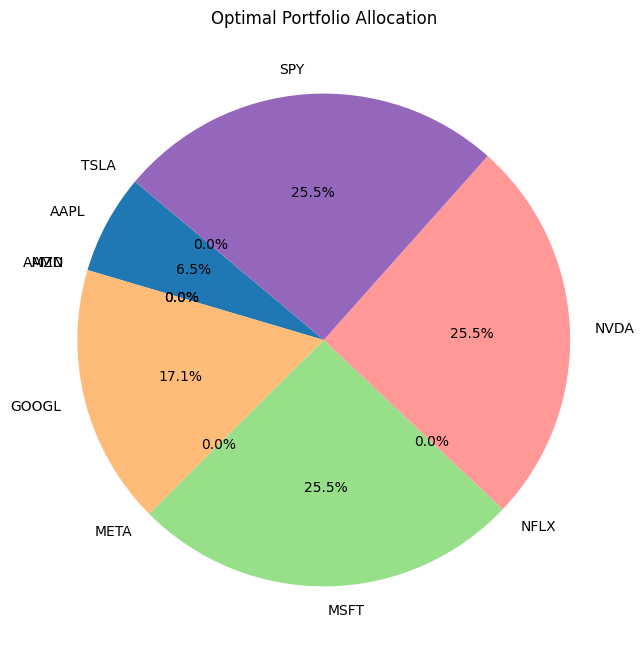

In [19]:
# Load data
filename = "data/stocks.csv"
print(f"Loading data from file: {filename}")
data = pd.read_csv(filename, index_col=0, parse_dates=True)

num_days = len(data)

returns = data.pct_change().dropna()
expected_returns = returns.mean() * num_days
covariance_matrix = returns.cov() * num_days

print("\nExpected annual returns:\n", expected_returns)
print("\nAnnual covariance matrix:\n", covariance_matrix)

tickers = data.columns
print("\nOptimizing portfolio...")

# Perform optimization
optimal_portfolio, optimal_sharpe = simulated_annealing_portfolio(
    assets=tickers,
    expected_returns=expected_returns.values,
    covariance_matrix=covariance_matrix.values,
    risk_free_rate=0.02,
    max_iter=20000,
    initial_temperature=100,
    cooling_rate=0.95,
    max_allocation=0.25,
    min_allocation=0.0
)

# Print optimal portfolio allocation
print("\nOptimal portfolio:")
for ticker, allocation in zip(tickers, optimal_portfolio):
    print(f"{ticker}: {allocation:.2%}")
print(f"\nOptimal Sharpe ratio: {optimal_sharpe:.4f}")

# Plot portfolio allocation as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    optimal_portfolio,
    labels=tickers,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Optimal Portfolio Allocation")
plt.show()


In [29]:
covariance_matrix

,AAPL,AMD,AMZN,GOOGL,META,MSFT,NFLX,NVDA,SPY,TSLA
AAPL,0.189958,0.209770,0.160187,0.143858,0.173644,0.139537,0.156618,0.232337,0.098765,0.215045
AMD,0.209770,0.555428,0.247138,0.218308,0.278730,0.199890,0.258435,0.481432,0.149372,0.362995
AMZN,0.160187,0.247138,0.308150,0.174493,0.231764,0.160011,0.237703,0.285461,0.113629,0.240977
GOOGL,0.143858,0.218308,0.174493,0.209515,0.211824,0.153597,0.173560,0.244728,0.100812,0.183529
META,0.173644,0.278730,0.231764,0.211824,0.500717,0.174577,0.294736,0.306920,0.123620,0.220979
MSFT,0.139537,0.199890,0.160011,0.153597,0.174577,0.169050,0.152005,0.232390,0.094763,0.177346
NFLX,0.156618,0.258435,0.237703,0.173560,0.294736,0.152005,0.591230,0.302353,0.113843,0.280331
NVDA,0.232337,0.481432,0.285461,0.244728,0.306920,0.232390,0.302353,0.604420,0.164166,0.394120
SPY,0.098765,0.149372,0.113629,0.100812,0.123620,0.094763,0.113843,0.164166,0.075591,0.135621
TSLA,0.215045,0.362995,0.240977,0.183529,0.220979,0.177346,0.280331,0.394120,0.135621,0.745225


array([[0.18995815, 0.20976987, 0.16018726, 0.14385824, 0.1736442 ,
        0.13953664, 0.1566183 , 0.23233682, 0.09876477, 0.21504482],
       [0.20976987, 0.55542847, 0.24713834, 0.21830787, 0.27873044,
        0.1998897 , 0.25843517, 0.48143248, 0.14937222, 0.36299456],
       [0.16018726, 0.24713834, 0.30814978, 0.17449268, 0.23176444,
        0.16001059, 0.23770321, 0.28546105, 0.11362892, 0.24097688],
       [0.14385824, 0.21830787, 0.17449268, 0.20951468, 0.21182423,
        0.153597  , 0.17356018, 0.2447281 , 0.10081217, 0.1835287 ],
       [0.1736442 , 0.27873044, 0.23176444, 0.21182423, 0.50071746,
        0.17457722, 0.29473627, 0.30691986, 0.1236203 , 0.2209786 ],
       [0.13953664, 0.1998897 , 0.16001059, 0.153597  , 0.17457722,
        0.16905035, 0.15200521, 0.23238979, 0.09476305, 0.17734558],
       [0.1566183 , 0.25843517, 0.23770321, 0.17356018, 0.29473627,
        0.15200521, 0.5912303 , 0.30235306, 0.11384302, 0.28033141],
       [0.23233682, 0.48143248, 0.2854610

In [23]:
tickers

Index(['AAPL', 'AMD', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NFLX', 'NVDA', 'SPY',
       'TSLA'],
      dtype='object')